# Notebook 7 - Summary Classification: Comparison of Classifiers

## 7.1 Load Data Set

For the last session, we are working with a new data set - but with the same structure: The Fashion MNIST Dataset. Each image in the Fashion MNIST dataset is again 28x28 pixels, unrolled into a 784-dimensional vector for modeling (our input space). We transfer the labels to one-hot encoded targets.

The original MNIST dataset (digits) serves as a benchmark for machine learning algorithms, as it presents a relatively simple, yet meaningful task: identifying handwritten digits. Despite its simplicity, the MNIST dataset is a great starting point for building and evaluating classification models.

**Task:**

As a first step, you only have to go through the next steps and inspect the data set.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [1]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load MNIST dataset
#mnist = fetch_openml('mnist_784', version=1, as_frame=False)
#X, y = mnist["data"], mnist["target"].astype(int)

# Fetch the Fashion-MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
# Separate the features (X) and labels (y)
X, y = fashion_mnist['data'], fashion_mnist['target']
# Convert labels to integers (if needed)
y = y.astype(np.int64)

In [4]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

# Split into training and test sets
# TODO: Change train size
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, train_size=10000, test_size=10000, random_state=42, stratify=y)

# Display shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

#TODO: Add normalization
X_train = X_train / 255.0
X_test = X_test / 255.0
print(X_train.max())

# Reshape the data to include a single channel for grayscale images (28x28x1)
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

Training set shape: (10000, 784) (10000, 10)
Test set shape: (10000, 784) (10000, 10)
1.0


In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_cnn[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(y_train[i])])
plt.show()

RuntimeError: In FT2Font: Can not load face (invalid stream operation; error code 0x55)

<Figure size 1000x1000 with 25 Axes>

--- 

## 7.2 Applying the LeNet-5 Architecture

We will continue to use the **LeNet-5 architecture**, a classic CNN architecture designed by Yann LeCun for handwritten digit recognition. LeNet-5 is well-suited for the MNIST dataset and includes several convolutional and pooling layers, followed by fully connected layers. 

![](lenet5.svg)

* Input Layer: Accepts 28x28 grayscale images as input, with each image normalized to a range of 0–1 (we added padding).
* Convolutional Layer 1: Applies 6 filters of size 5x5 with stride 1 and ReLU activation, producing 6 feature maps. The resulting feature maps have dimensions of 24x24.
* Pooling Layer 1 (Average Pooling): Averages over 2x2 regions, reducing each feature map to a size of 12x12. Pooling reduces the spatial dimensions and adds robustness to small spatial translations.
* Convolutional Layer 2: Applies 16 filters of size 5x5 with stride 1 and ReLU activation, producing 16 feature maps. The resulting feature maps have dimensions of 8x8.
* Pooling Layer 2 (Average Pooling): Another 2x2 average pooling layer, reducing each feature map to a size of 4x4.
* Fully Connected Layers:
   - Fully Connected Layer 1: Flattens the output from the convolutional layers and connects to a fully connected layer with 120 neurons and ReLU activation.
   - Fully Connected Layer 2: Connects to a fully connected layer with 84 neurons and ReLU activation.
* Output Layer: The final layer is a fully connected layer with 10 neurons and softmax activation, used for classification into the 10 digit classes.

**Tasks:**

Your tasks are to try out some variations:

* increasing training data (for further variations might have to go back to smaller data set again to speed up training)
* using normalization on the input data (gray scale values are encoded from 0 to 255 = scale it into the range $[0,1]$)
* activation function (last week we already used ReLU, but originally LeNet used sigmoid): compare ReLU and sigmoid (on smaller training data set); how does this interacts with normalization?
* adding Dropout as regularization
* using early stopping
* and Batch Normalization

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the LeNet-5 architecture
model_lenet5 = tf.keras.models.Sequential([
    # Convolutional Layer 1: 6 filters of size 5x5, stride 1, with ReLU activation
    # TODO: activation can be replaced with 'relu' instead of 'sigmoid'
    #tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(28, 28, 1), padding='same'),
    # TODO: Batch normalization - remove the single line for Conv2D and replace it by the three following steps
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1, input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Average Pooling Layer 1: pool size 2x2
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    # Convolutional Layer 2: 16 filters of size 5x5, stride 1, with ReLU activation
    #tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1, activation='relu', padding='same'),
    # TODO: Batch normalization - remove the single line for Conv2D and replace it by the three following steps
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Average Pooling Layer 2: pool size 2x2
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    # Flatten layer to reshape 2D feature maps to a 1D vector
    tf.keras.layers.Flatten(),
    # Fully Connected Layer 1: 120 units with ReLU activation
    tf.keras.layers.Dense(120, activation='relu'),
    # TODO: Batch normalization - remove the single line for Dense and replace it by the three following steps
    #tf.keras.layers.Dense(120),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    # TODO: Dropout
    #tf.keras.layers.Dropout(0.5),
    # Fully Connected Layer 2: 84 units with ReLU activation
    tf.keras.layers.Dense(84, activation='relu'),
    # TODO: Batch normalization - remove the single line for Dense and replace it by the three following steps
    #tf.keras.layers.Dense(84),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    # TODO: Dropout
    #tf.keras.layers.Dropout(0.5),
    # Output Layer: 10 units with softmax activation for classification
    tf.keras.layers.Dense(10, activation='softmax')
    # Originally used Radial Basis Functions in LeNet-5
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (e.g., validation loss)
    patience=5,            # Number of epochs with no improvement to stop training
    restore_best_weights=True  # Restore model weights from the epoch with the best metric value
)

# Create the Adam optimizer with a specific learning rate
adam_optimizer = Adam()  # Set your desired learning rate (default is 0.001, learning_rate is a parameter you can set)

# Compile the model
model_lenet5.compile(optimizer=adam_optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_lenet5 = model_lenet5.fit(X_train_cnn, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_test_cnn, y_test),
# TODO: Test the early stopping callback
#                                  callbacks=[early_stopping],
                                  verbose=1)

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(history_lenet5.history['accuracy'], label='Train Accuracy')
plt.plot(history_lenet5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy for LeNet-5 Architecture")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model_lenet5.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


ImportError: DLL load failed while importing _errors: The specified procedure could not be found.

In [20]:
predictions = model_lenet5.predict(X_test_cnn)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


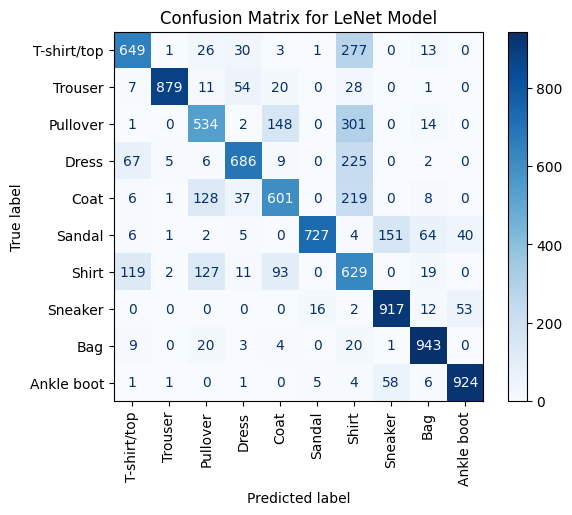

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predicted_classes)

# Display the confusion matrix with class names
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for LeNet Model")
plt.show()


## Remarks on different topics / Explanation

### Normalization
Normalization scales input features to a common range, typically [0, 1] or [-1, 1], ensuring that each feature contributes equally to the model's training. It is especially critical when using activation functions like sigmoid or tanh, which are sensitive to input magnitude and can saturate, leading to vanishing gradients. With ReLU, normalization becomes less critical because ReLU does not saturate for positive inputs. However, normalized inputs still help by improving convergence speed and ensuring consistent gradient magnitudes across layers.

### Effect of More Data
Adding more data can significantly improve model performance, especially by reducing overfitting and enhancing generalization. Models trained on larger datasets can better capture the underlying patterns and variability of the data, leading to improved predictions on unseen samples. However, simply adding more data without diversity or relevance may not yield benefits. High-quality, diverse data ensures that the model is exposed to a wide range of scenarios during training, boosting its ability to generalize.

### Dropout and Regularization
Dropout is a popular regularization technique that prevents overfitting by randomly setting a fraction of neurons to zero during training. This forces the network to learn more robust features, as it cannot rely on any single neuron. Dropout complements other regularization techniques, such as L2 regularization, which penalizes large weights to reduce model complexity. While dropout is effective, using it excessively can lead to underfitting, so it should be applied judiciously, especially in conjunction with Batch Normalization.

### Early Stopping
Early stopping halts training when the model's performance on a validation set stops improving for a specified number of epochs. This prevents overfitting, as the model stops learning patterns specific to the training data. By restoring the weights from the epoch with the best validation performance, early stopping ensures optimal generalization. It is particularly effective in scenarios where the model is prone to overfitting or when computational resources are limited.

### Batch Normalization
Batch Normalization (BatchNorm) normalizes the activations of each layer by adjusting and scaling them during training. This stabilizes learning, reduces the risk of vanishing or exploding gradients, and allows for higher learning rates. BatchNorm also acts as a form of regularization, reducing the need for other techniques like dropout. It is especially useful in deeper networks, where it accelerates convergence and makes the model more robust to weight initialization and learning rate choices.


In [22]:
def plot_image(i, predictions_array, true_array, img):
  true_label, img = np.argmax(true_array[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_array):
  true_label = np.argmax(true_array[i])
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

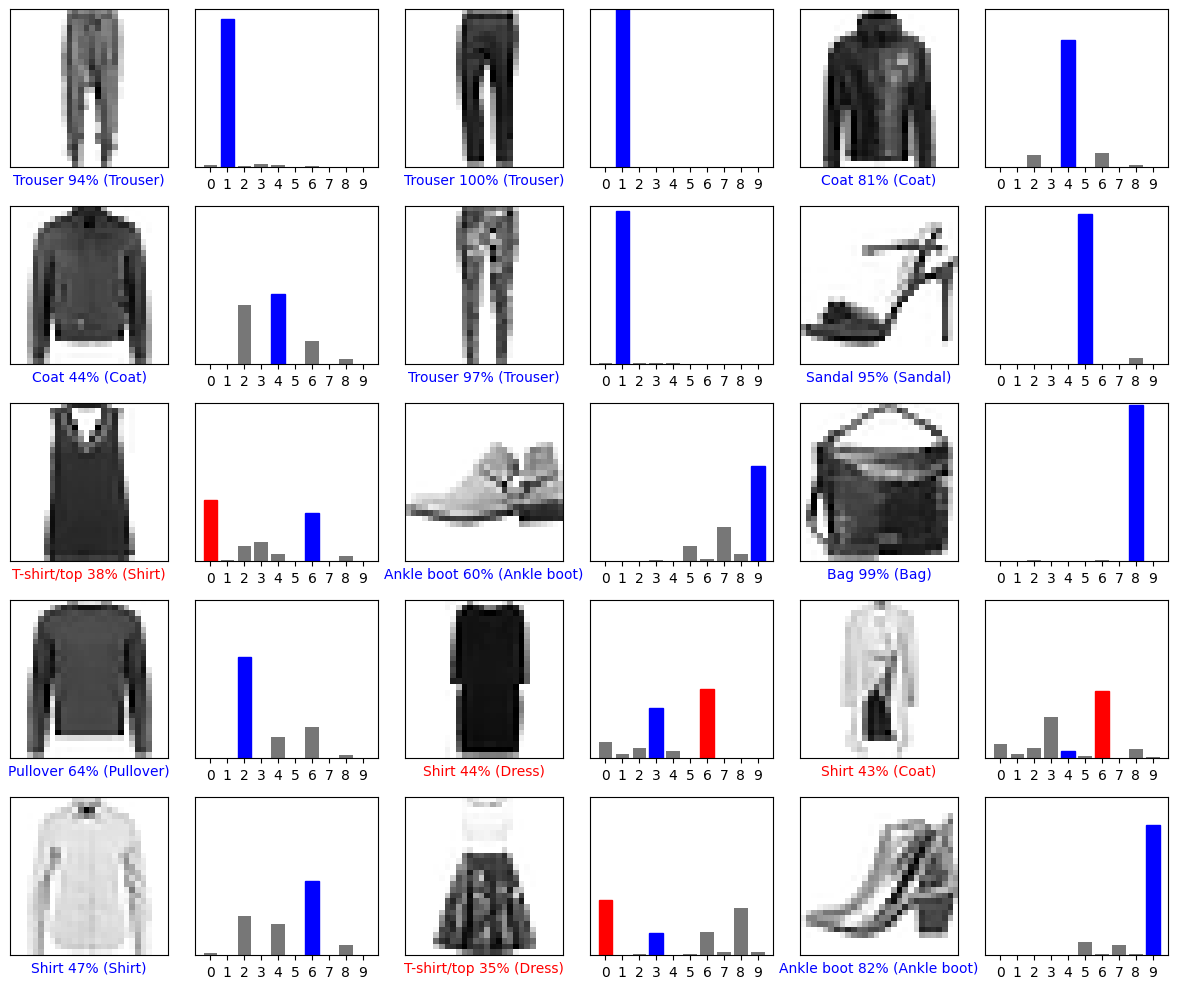

In [23]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test_cnn)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()


---

## 7.3 Logistic Regression as a baseline

The Fashion MNIST dataset is a more difficult task (overall, still an easy task -- could you explain why?). We want to get a first impression how difficult it actually is and simply apply logistic regression on this dataset as a baseline. And afterwards compute the confusion matrix.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Flatten the images back to 1D for logistic regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train a logistic regression model
logistic_regression = LogisticRegression(max_iter=100, multi_class='multinomial', solver='saga', random_state=42)
logistic_regression.fit(X_train_flat, y_train.argmax(axis=1))

# Predict on the test set
y_pred = logistic_regression.predict(X_test_flat)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Test accuracy:", test_accuracy)

/Users/marvcc/Private/GitPrivate/deep-reinforcement-learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.7985


/Users/marvcc/Private/GitPrivate/deep-reinforcement-learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


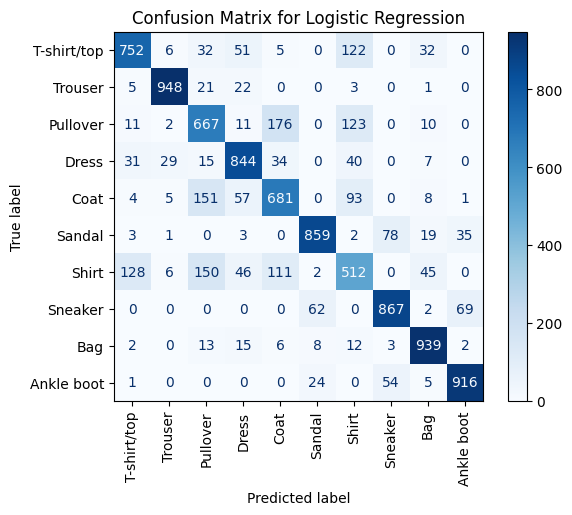

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)

# Display the confusion matrix with class names
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Logistic Regression")
plt.show()


Logistic regression works not bad on this dataset and seems to generalize also quite well. 

Why are convolutional neural networks not outperforming logistic regression? How is the structure of the data helpful for other classification methods, but would not be required for convolutional methods?

<div style="text-align: right;">
<i>This notebook has been created with the help of ChatGPT-4, 14.11.2024; Explanations were initially generated and afterwards edited;</i>
</div>